### About

Demonstration of Mr.ASH penalized regression on trendfiltering problems and optimization of $w_k$

In [1]:
#collapse-hide

import numpy as np
import pandas as pd

from mrashpen.inference.penalized_regression import PenalizedRegression as PLR
from mrashpen.inference.mrash_wrapR          import MrASHR
from mrashpen.models.plr_ash                 import PenalizedMrASH
from mrashpen.models.normal_means_ash_scaled import NormalMeansASHScaled
from mrashpen.inference.ebfit                import ebfit
from mrashpen.inference                      import lbfgsfit
from mrashpen.utils                          import R_lasso
from mrashpen.utils                          import R_genlasso
from mrashpen.models                         import mixture_gaussian as mix_gauss

import sys
sys.path.append('/home/saikat/Documents/work/sparse-regression/simulation/eb-linreg-dsc/dsc/functions')
import simulate

import matplotlib.pyplot as plt
from pymir import mpl_stylesheet
from pymir import mpl_utils
mpl_stylesheet.banskt_presentation(splinecolor = 'black')

In [2]:
def center_and_scale(Z):
    dim = Z.ndim
    if dim == 1:
        Znew = Z / np.std(Z)
        Znew = Znew - np.mean(Znew)
    elif dim == 2:
        Znew = Z / np.std(Z, axis = 0)
        Znew = Znew - np.mean(Znew, axis = 0).reshape(1, -1)
    return Znew

def initialize_ash_prior(k, scale = 2, sparsity = None):
    w = np.zeros(k)
    w[0] = 1 / k if sparsity is None else sparsity
    w[1:(k-1)] = np.repeat((1 - w[0])/(k-1), (k - 2))
    w[k-1] = 1 - np.sum(w)
    sk2 = np.square((np.power(scale, np.arange(k) / k) - 1))
    prior_grid = np.sqrt(sk2)
    return w, prior_grid

def plot_trendfilter_mrashpen(X, y, beta, ytest, bhat,
                              intercept = 0, title = None):
    n = y.shape[0]
    p = X.shape[1]

    ypred = np.dot(X, bhat) + intercept
    fig = plt.figure(figsize = (12, 6))
    ax1 = fig.add_subplot(121)
    ax2 = fig.add_subplot(122)
    ax1.scatter(np.arange(n), ytest, edgecolor = 'black', facecolor='white')
    ax1.plot(np.arange(n), ypred)
    ax1.set_xlabel("Sample index")
    ax1.set_ylabel("Y")

    ax2.scatter(np.arange(p), beta, edgecolor = 'black', facecolor = 'white')
    ax2.scatter(np.arange(p), bhat, s = 40, color = 'firebrick')
    ax2.set_xlabel("Sample index")
    ax2.set_ylabel("b")
    
    if title is not None:
        fig.suptitle(title)

    plt.tight_layout()
    plt.show()

def plot_convergence(objs, methods, nwarm, eps = 1e-8):
    fig = plt.figure(figsize = (12, 6))
    ax1 = fig.add_subplot(111)

    objmin  = np.min([np.min(x) for x in objs])

    for obj, method, iteq in zip(objs, methods, nwarm):
        m_obj = np.array(obj)[iteq:] - objmin
        m_obj = m_obj[m_obj > 0]
        ax1.plot(range(iteq, len(m_obj) + iteq), np.log10(m_obj), label = method, 
                 marker = 'o', markersize = 1)
    ax1.legend()

    ax1.set_xlabel("Number of Iterations")
    ax1.set_ylabel("log( max(ELBO) - ELBO )")

    plt.show()
    return

def linreg_summary_df(sigma2, objs, methods):
    data     = [[strue * strue,  '-', '-']]
    rownames = ['True']
    for obj, method in zip(objs, methods):
        if isinstance(obj.elbo_path, list) or isinstance(obj.elbo_path, np.ndarray):
            elbo = obj.elbo_path[-1]
        else:
            elbo = obj.elbo_path
        data.append([obj.residual_var, elbo, obj.niter])
        rownames.append(method)
    colnames = ['sigma2', 'ELBO', 'niter']
    df = pd.DataFrame.from_records(data, columns = colnames, index = rownames)
    return df

In [3]:
n = 500
p = 500
p_causal = 10
snr = 10
k = 10

X, y, Xtest, ytest, btrue, strue = simulate.changepoint_predictors (n, p, p_causal, snr, 
                                                                    k = 0, signal = 'gamma', seed = 200)
wk, sk = initialize_ash_prior(k, scale = 4)

In [4]:
genlasso_a0, genlasso_b, genlasso_fit = R_genlasso.fit(X, y, order = 0)

Fold 1 ... Fold 2 ... Fold 3 ... Fold 4 ... Fold 5 ... 



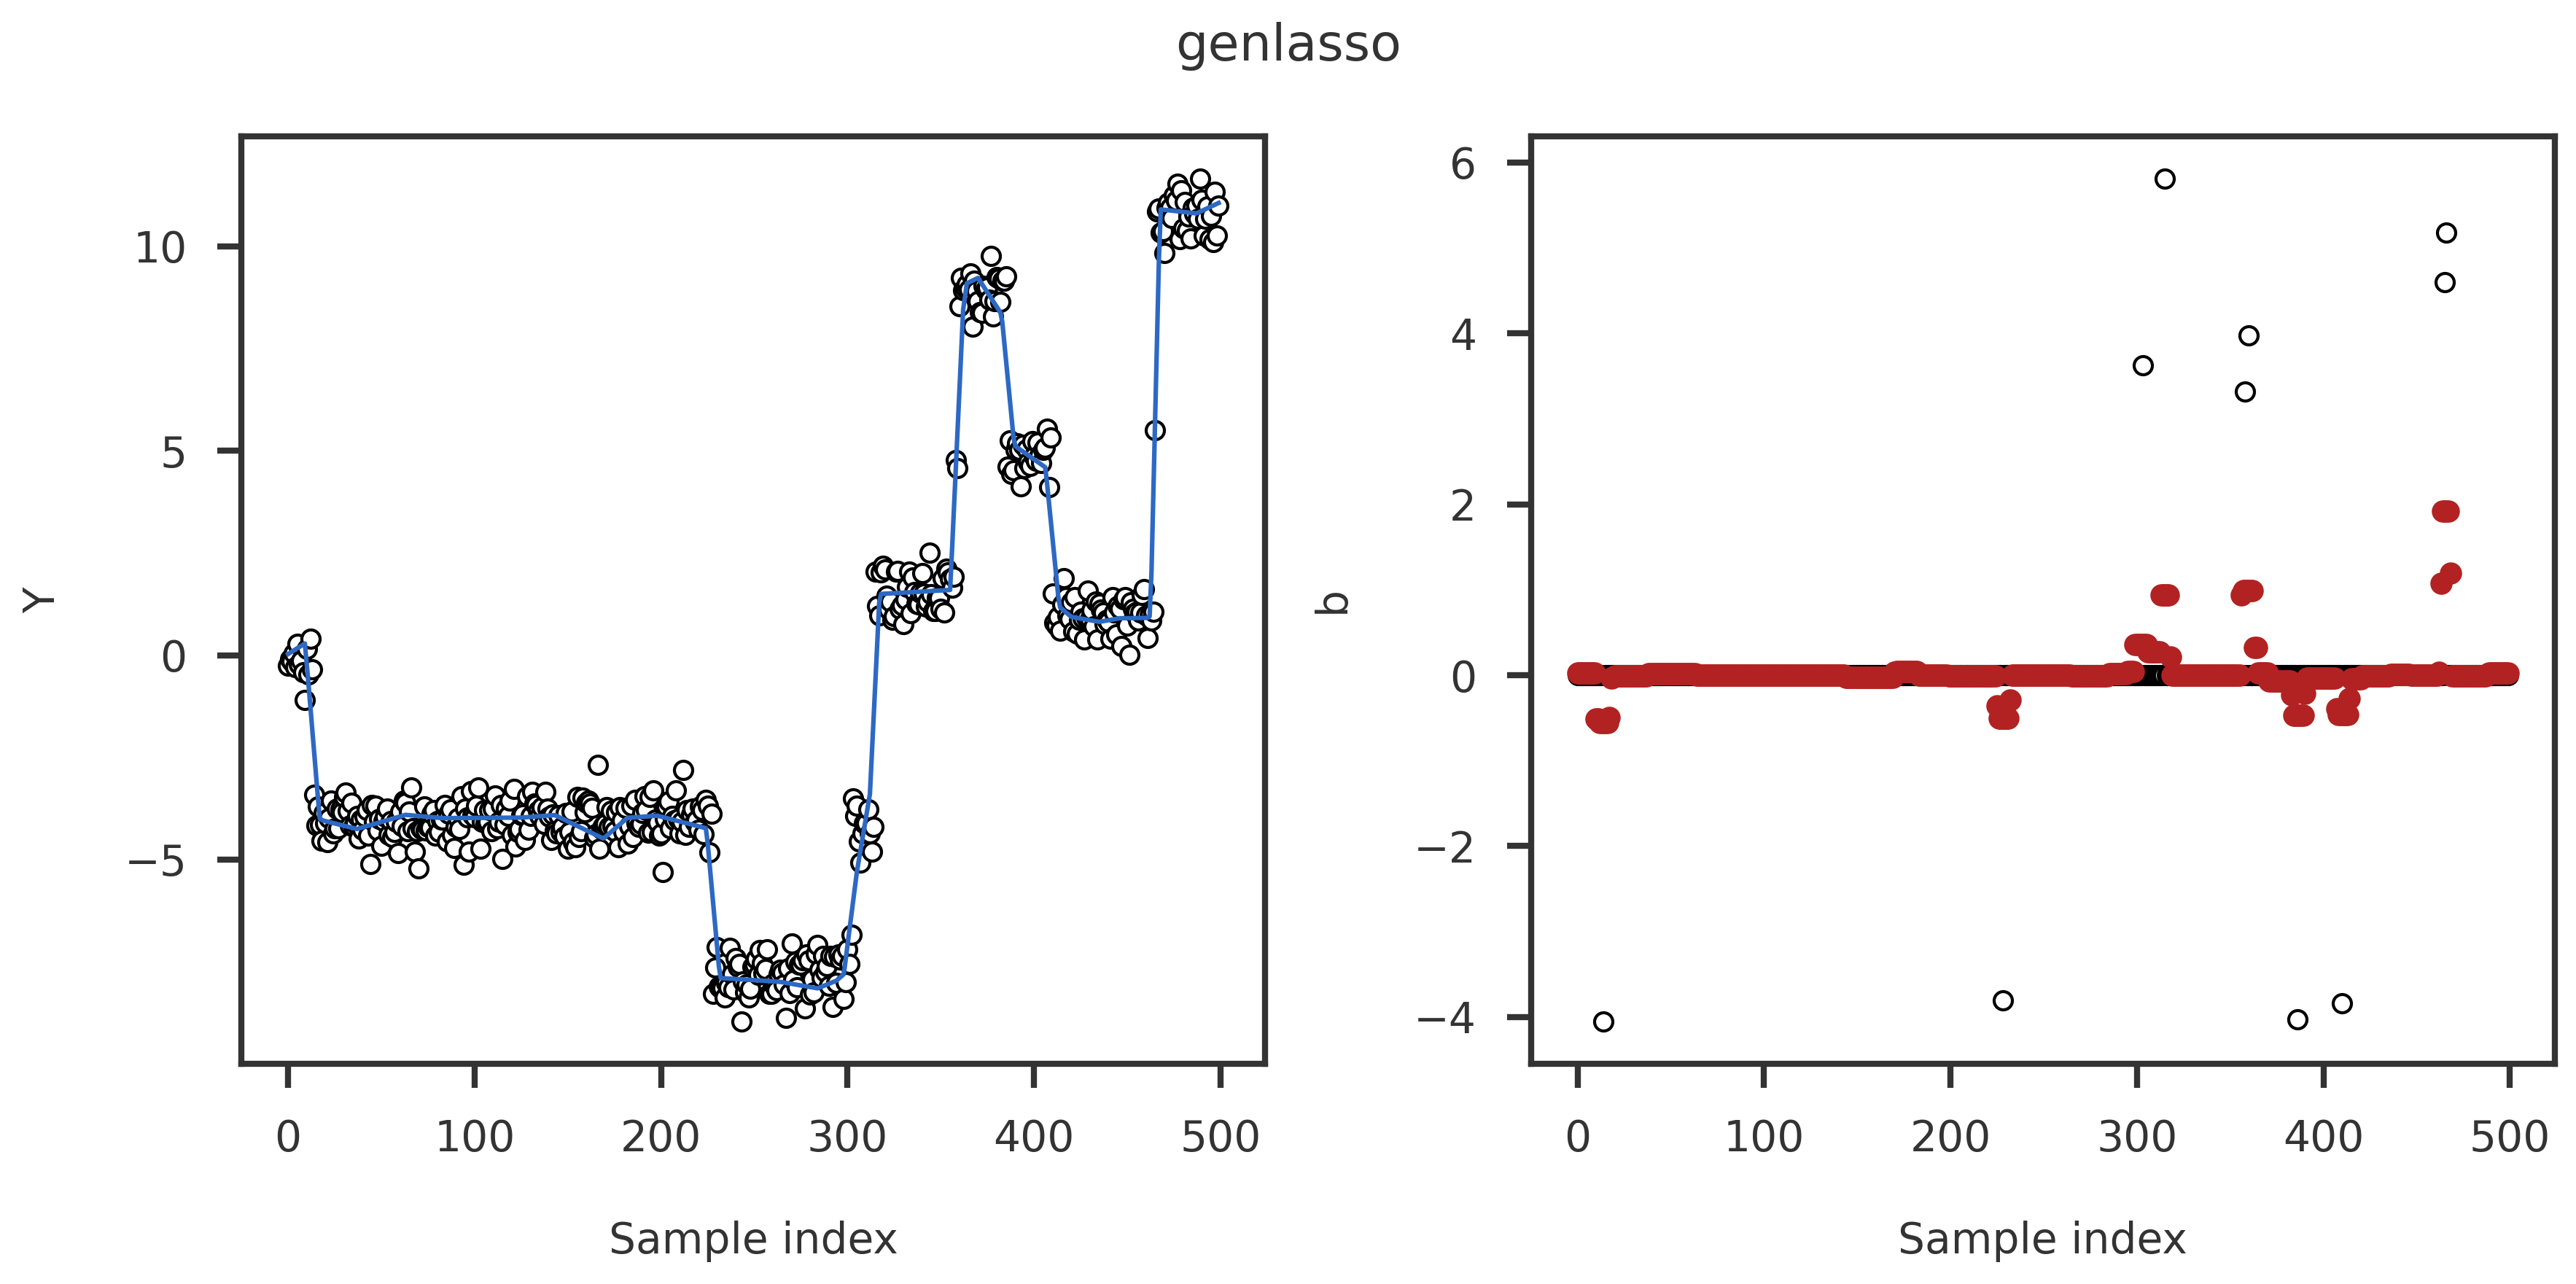

In [5]:
plot_trendfilter_mrashpen(X, y, btrue, ytest, 
                     genlasso_b, intercept = genlasso_a0, title = 'genlasso')

In [6]:
'''
Genlasso results
'''
genlasso_a0, genlasso_b, _ = R_genlasso.fit(X, y, order = 0)
genlasso_b = genlasso_b.reshape(-1,)
s2init = np.var(y - np.dot(X, genlasso_b) - genlasso_a0)
print ("Genlasso initialization")


'''
Initialization of theta and w for mr.ash.pen
'''
plr_init = PLR(method = 'L-BFGS-B', is_prior_scaled = True, optimize_s = False,
               function_call = 'python',
               debug = False, display_progress = False, calculate_elbo = False, 
               maxiter = 2000, tol = 1e-8)
plr_init.fit(np.eye(p), genlasso_b, sk, binit = genlasso_b, winit = wk, s2init = s2init)
theta_init = plr_init.theta
winit = plr_init.prior
# winit = mix_gauss.emfit(genlasso_b, sk)

'''
Use the initial theta for mr.ash.pen
'''
plr_lbfgs = PLR(method = 'L-BFGS-B', is_prior_scaled = True, function_call = 'python',
                debug = False, display_progress = False, calculate_elbo = True, 
                maxiter = 2000, tol = 1e-8)
plr_lbfgs.fit(X, y, sk, binit = theta_init, winit = winit, s2init = s2init, is_binit_coef = False)


'''
Use the initial coefficients for mr.ash.pen (EM)
'''
plr_eb = ebfit(X, y, sk, binit = genlasso_b, winit = winit, s2init = s2init, is_binit_coef = False,
               maxiter = 200, qb_maxiter = 50, calculate_elbo = True)


'''
mr.ash.alpha
'''
mrash_r = MrASHR(option = "r2py", debug = False)
mrash_r.fit(X, y, sk, binit = genlasso_b, winit = winit, s2init = s2init)


'''
mr.ash.alpha (init)
'''
mrash_r_init = MrASHR(option = "r2py", debug = False)
mrash_r_init.fit(X, y, sk, binit = plr_lbfgs.coef, winit = plr_lbfgs.prior, s2init = plr_lbfgs.residual_var)

Fold 1 ... Fold 2 ... Fold 3 ... Fold 4 ... Fold 5 ... 

Genlasso initialization
inv_binit is None
mr.ash.pen terminated at iteration 23.
inv_binit is None
mr.ash.pen terminated at iteration 540.
inv_binit is [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 

inv_binit is [ 4.31614712e-02  4.07547722e-02  3.59928323e-02  3.17524219e-02
  2.68229480e-02  2.13150989e-02  1.86148692e-02  1.46763928e-02
  9.87257058e-03  5.91673529e-03  6.98657337e-03  3.53152576e-02
 -6.41597610e-02  7.91457423e-02 -1.84167624e+00 -9.18701020e-01
 -9.87643425e-03 -3.96503129e-02  1.01564775e-02  3.05759650e-03
  1.55887104e-03  1.87187442e-03  2.12546829e-03  2.01152624e-03
  1.48797830e-03  1.69479579e-03  7.26755792e-04  3.57914988e-04
  8.94738228e-04  1.17240035e-03  2.27653466e-04  2.48811710e-04
  9.28423653e-04  5.16284359e-04  2.06266650e-03  2.05246865e-03
  1.80207106e-03  3.35436933e-03  5.14773732e-03  5.28411845e-03
  4.80579931e-03  5.40845420e-03  6.14240949e-03  6.67269452e-03
  7.43838353e-03  6.79682219e-03  6.63230585e-03  6.88608098e-03
  7.93900410e-03  8.55837373e-03  1.06729130e-02  1.14647593e-02
  1.10077420e-02  1.08336335e-02  8.08307133e-03  7.65925627e-03
  8.65470014e-03  7.27205309e-03  6.51437679e-03  6.23650268e-03
  8.44587404

inv_binit is [ 4.09945181e-02  3.95609872e-02  3.58385079e-02  3.25338737e-02
  2.90902775e-02  2.54405962e-02  2.34581173e-02  2.02863899e-02
  1.62088918e-02  1.28193373e-02  9.31549806e-03  7.88794424e-03
  3.18720361e-03  3.23583875e-03 -2.28051736e+00 -4.54074731e-01
  2.04643248e-04  9.41361313e-04  1.23927231e-03  9.43454187e-04
  2.07909924e-03  2.41203583e-03  2.68467801e-03  2.58030316e-03
  2.05483690e-03  2.27993390e-03  1.29626512e-03  9.28462394e-04
  1.49334855e-03  1.79207766e-03  8.29520195e-04  8.63295521e-04
  1.57797346e-03  1.16422478e-03  2.77894245e-03  2.78232506e-03
  2.53642484e-03  4.16384598e-03  5.52246887e-03  5.65493682e-03
  5.16327499e-03  5.76953481e-03  6.50847061e-03  7.04050881e-03
  7.81020061e-03  7.15671651e-03  6.98495801e-03  7.23764349e-03
  8.30034573e-03  8.92293745e-03  1.10491978e-02  1.18417424e-02
  1.13827150e-02  1.12065568e-02  8.42237054e-03  7.98629875e-03
  8.99582114e-03  7.58082788e-03  6.79815152e-03  6.50604399e-03
  8.76697556

inv_binit is [ 4.00589038e-02  3.84124121e-02  3.44578152e-02  1.21774368e-02
  2.77077011e-02  2.53998652e-02  2.32041435e-02  2.01592747e-02
  1.63509148e-02  1.31147024e-02  9.53068699e-03  7.46201173e-03
  3.65297677e-03  2.24474763e-03 -2.18348793e+00 -5.51353027e-01
  8.90254331e-04  1.43679133e-03  1.36949567e-03  1.27546502e-03
  2.46299898e-03  2.79615548e-03  3.06901617e-03  2.96448416e-03
  2.43848637e-03  2.66370559e-03  1.67929675e-03  1.31126937e-03
  1.87630085e-03  2.17513498e-03  1.21199339e-03  1.24566982e-03
  1.96059300e-03  1.54649685e-03  3.16258352e-03  3.16588072e-03
  2.91956003e-03  4.54967489e-03  5.90036695e-03  6.03255313e-03
  5.53964323e-03  6.14632753e-03  6.88599961e-03  7.41847548e-03
  8.18907826e-03  7.53381112e-03  7.36116728e-03  7.61374946e-03
  8.67790262e-03  9.30106541e-03  1.14295359e-02  1.22215749e-02
  1.17620178e-02  1.15851887e-02  8.79628557e-03  8.35863208e-03
  9.36940722e-03  7.95086229e-03  7.16589877e-03  6.87246397e-03
  9.13704612

inv_binit is [ 3.91381518e-02  4.02196157e-02  3.40939275e-02  3.23044167e-02
  2.94255955e-02  2.52226344e-02  2.31997030e-02  2.02007560e-02
  1.64074613e-02  1.31655205e-02  9.58014520e-03  7.44457768e-03
  3.74410725e-03  2.12534915e-03 -2.14949284e+00 -5.85331048e-01
  1.05796207e-03  1.57552590e-03  1.45299315e-03  1.38930431e-03
  2.58437221e-03  2.91736767e-03  3.19007294e-03  3.08544866e-03
  2.55941509e-03  2.78448937e-03  1.80007562e-03  1.43196067e-03
  1.99681980e-03  2.29550392e-03  1.33232130e-03  1.36586935e-03
  2.08061234e-03  1.66642124e-03  3.28223798e-03  3.28541219e-03
  3.03899321e-03  4.66873024e-03  6.01727185e-03  6.14920416e-03
  5.65637923e-03  6.26254985e-03  7.00153199e-03  7.53338154e-03
  8.30303034e-03  7.64824638e-03  7.47556793e-03  7.72773250e-03
  8.79055972e-03  9.41272887e-03  1.15376034e-02  1.23280812e-02
  1.18691435e-02  1.16924374e-02  8.90759339e-03  8.47021097e-03
  9.47955719e-03  8.06238275e-03  7.27781885e-03  6.98433081e-03
  9.24657694

inv_binit is [ 4.12926894e-02  3.88121978e-02  3.26664469e-02  3.17848064e-02
  2.93269750e-02  2.52662971e-02  2.32361564e-02  2.02105896e-02
  1.64248590e-02  1.31797595e-02  9.58815784e-03  7.46401676e-03
  3.74192503e-03  2.15168833e-03 -2.14758624e+00 -5.87145282e-01
  1.04667601e-03  1.56774811e-03  1.45235933e-03  1.38489744e-03
  2.57842068e-03  2.91125294e-03  3.18382066e-03  3.07935658e-03
  2.55378042e-03  2.77877494e-03  1.79502174e-03  1.42713742e-03
  1.99181496e-03  2.29040729e-03  1.32775223e-03  1.36136070e-03
  2.07585765e-03  1.66193892e-03  3.27683039e-03  3.28007856e-03
  3.03392508e-03  4.66226973e-03  6.00962616e-03  6.14150171e-03
  5.64933145e-03  6.25490843e-03  6.99313681e-03  7.52448578e-03
  8.29342388e-03  7.63942570e-03  7.46703748e-03  7.71902787e-03
  8.78090432e-03  9.40268278e-03  1.15271480e-02  1.23181264e-02
  1.18589913e-02  1.16822991e-02  8.89845501e-03  8.46157188e-03
  9.47018324e-03  8.05435209e-03  7.27071466e-03  6.97764356e-03
  9.23779019

inv_binit is [ 3.97271242e-02  3.87847724e-02  3.54842898e-02  3.14746308e-02
  2.93573323e-02  2.52401594e-02  2.32332662e-02  2.02271324e-02
  1.64243003e-02  1.31810514e-02  9.59353924e-03  7.45627137e-03
  3.75920963e-03  2.13125320e-03 -2.14368748e+00 -5.91047049e-01
  1.09055238e-03  1.60660316e-03  1.48154895e-03  1.41928403e-03
  2.61418012e-03  2.94697088e-03  3.21949175e-03  3.11493190e-03
  2.58920673e-03  2.81414525e-03  1.83019971e-03  1.46220095e-03
  2.02684057e-03  2.32537895e-03  1.36254998e-03  1.39607347e-03
  2.11054566e-03  1.69649929e-03  3.31150061e-03  3.31466189e-03
  3.06838398e-03  4.69688519e-03  6.04396068e-03  6.17573788e-03
  5.68346977e-03  6.28894819e-03  7.02700926e-03  7.55815204e-03
  8.32672572e-03  7.67287195e-03  7.50043223e-03  7.75225955e-03
  8.81359730e-03  9.43488406e-03  1.15570264e-02  1.23467932e-02
  1.18882623e-02  1.17117420e-02  8.93051154e-03  8.49373963e-03
  9.50168524e-03  8.08645749e-03  7.30288467e-03  7.00973298e-03
  9.26904034

inv_binit is [ 4.04866671e-02  3.87841951e-02  3.54569055e-02  3.18509975e-02
  2.91768453e-02  2.52547074e-02  2.32343130e-02  2.02153600e-02
  1.64178637e-02  1.31777905e-02  9.59623303e-03  7.45389868e-03
  3.76630629e-03  2.12901454e-03 -2.14235047e+00 -5.92374382e-01
  1.10375470e-03  1.61884406e-03  1.49154549e-03  1.43036126e-03
  2.62613101e-03  2.95910129e-03  3.23177711e-03  3.12705503e-03
  2.60086088e-03  2.82588892e-03  1.84128505e-03  1.47306831e-03
  2.03788993e-03  2.33652498e-03  1.37319072e-03  1.40666203e-03
  2.12137459e-03  1.70707272e-03  3.32299432e-03  3.32608686e-03
  3.07954649e-03  4.70953890e-03  6.05827191e-03  6.19015291e-03
  5.69706120e-03  6.30333911e-03  7.04250261e-03  7.57446835e-03
  8.34434686e-03  7.68916263e-03  7.51630055e-03  7.76845813e-03
  8.83162732e-03  9.45393936e-03  1.15793063e-02  1.23696547e-02
  1.19106091e-02  1.17337639e-02  8.94797070e-03  8.51028434e-03
  9.51990048e-03  8.10204250e-03  7.31706654e-03  7.02335651e-03
  9.28629709

inv_binit is [ 4.04804259e-02  3.87841808e-02  3.54618148e-02  3.18750937e-02
  2.91780960e-02  2.52545992e-02  2.32343085e-02  2.02154236e-02
  1.64178875e-02  1.31777988e-02  9.59622789e-03  7.45390176e-03
  3.76629828e-03  2.12901631e-03 -2.14235469e+00 -5.92369280e-01
  1.10375025e-03  1.61884036e-03  1.49154390e-03  1.43035861e-03
  2.62612709e-03  2.95909700e-03  3.23177248e-03  3.12705057e-03
  2.60085708e-03  2.82588490e-03  1.84128196e-03  1.47306546e-03
  2.03788672e-03  2.33652154e-03  1.37318795e-03  1.40665925e-03
  2.12137136e-03  1.70706979e-03  3.32298987e-03  3.32608242e-03
  3.07954238e-03  4.70953222e-03  6.05826196e-03  6.19014264e-03
  5.69705243e-03  6.30332865e-03  7.04248972e-03  7.57445345e-03
  8.34432861e-03  7.68914751e-03  7.51628627e-03  7.76844294e-03
  8.83160730e-03  9.45391618e-03  1.15792701e-02  1.23696140e-02
  1.19105715e-02  1.17337277e-02  8.94795117e-03  8.51026705e-03
  9.51987839e-03  8.10202725e-03  7.31705433e-03  7.02334534e-03
  9.28627697

inv_binit is [ 4.04711078e-02  3.87841740e-02  3.54694229e-02  3.19129883e-02
  2.91800789e-02  2.52544317e-02  2.32343053e-02  2.02155286e-02
  1.64179283e-02  1.31778144e-02  9.59622134e-03  7.45390833e-03
  3.76628682e-03  2.12902059e-03 -2.14236215e+00 -5.92361669e-01
  1.10374445e-03  1.61883579e-03  1.49154277e-03  1.43035580e-03
  2.62612226e-03  2.95909159e-03  3.23176655e-03  3.12704495e-03
  2.60085254e-03  2.82588001e-03  1.84127860e-03  1.47306251e-03
  2.03788322e-03  2.33651768e-03  1.37318520e-03  1.40665651e-03
  2.12136792e-03  1.70706684e-03  3.32298455e-03  3.32607715e-03
  3.07953764e-03  4.70952341e-03  6.05824799e-03  6.19012818e-03
  5.69704039e-03  6.30331396e-03  7.04247116e-03  7.57443175e-03
  8.34430159e-03  7.68912551e-03  7.51626564e-03  7.76842089e-03
  8.83157760e-03  9.45388147e-03  1.15792149e-02  1.23695514e-02
  1.19105140e-02  1.17336725e-02  8.94792243e-03  8.51024191e-03
  9.51984564e-03  8.10200542e-03  7.31703734e-03  7.02333003e-03
  9.28624749

Mr.ASH terminated at iteration 950.
Mr.ASH terminated at iteration 223.


In [107]:
'''
Use the initial theta for mr.ash.pen
'''
plr_lbfgs = PLR(method = 'L-BFGS-B', is_prior_scaled = True, function_call = 'python',
                debug = False, display_progress = False, calculate_elbo = True, 
                maxiter = 2000, tol = 1e-8)
plr_lbfgs.fit(X, y, sk, binit = genlasso_b, winit = winit, s2init = s2init)

mr.ash.pen terminated at iteration 0.


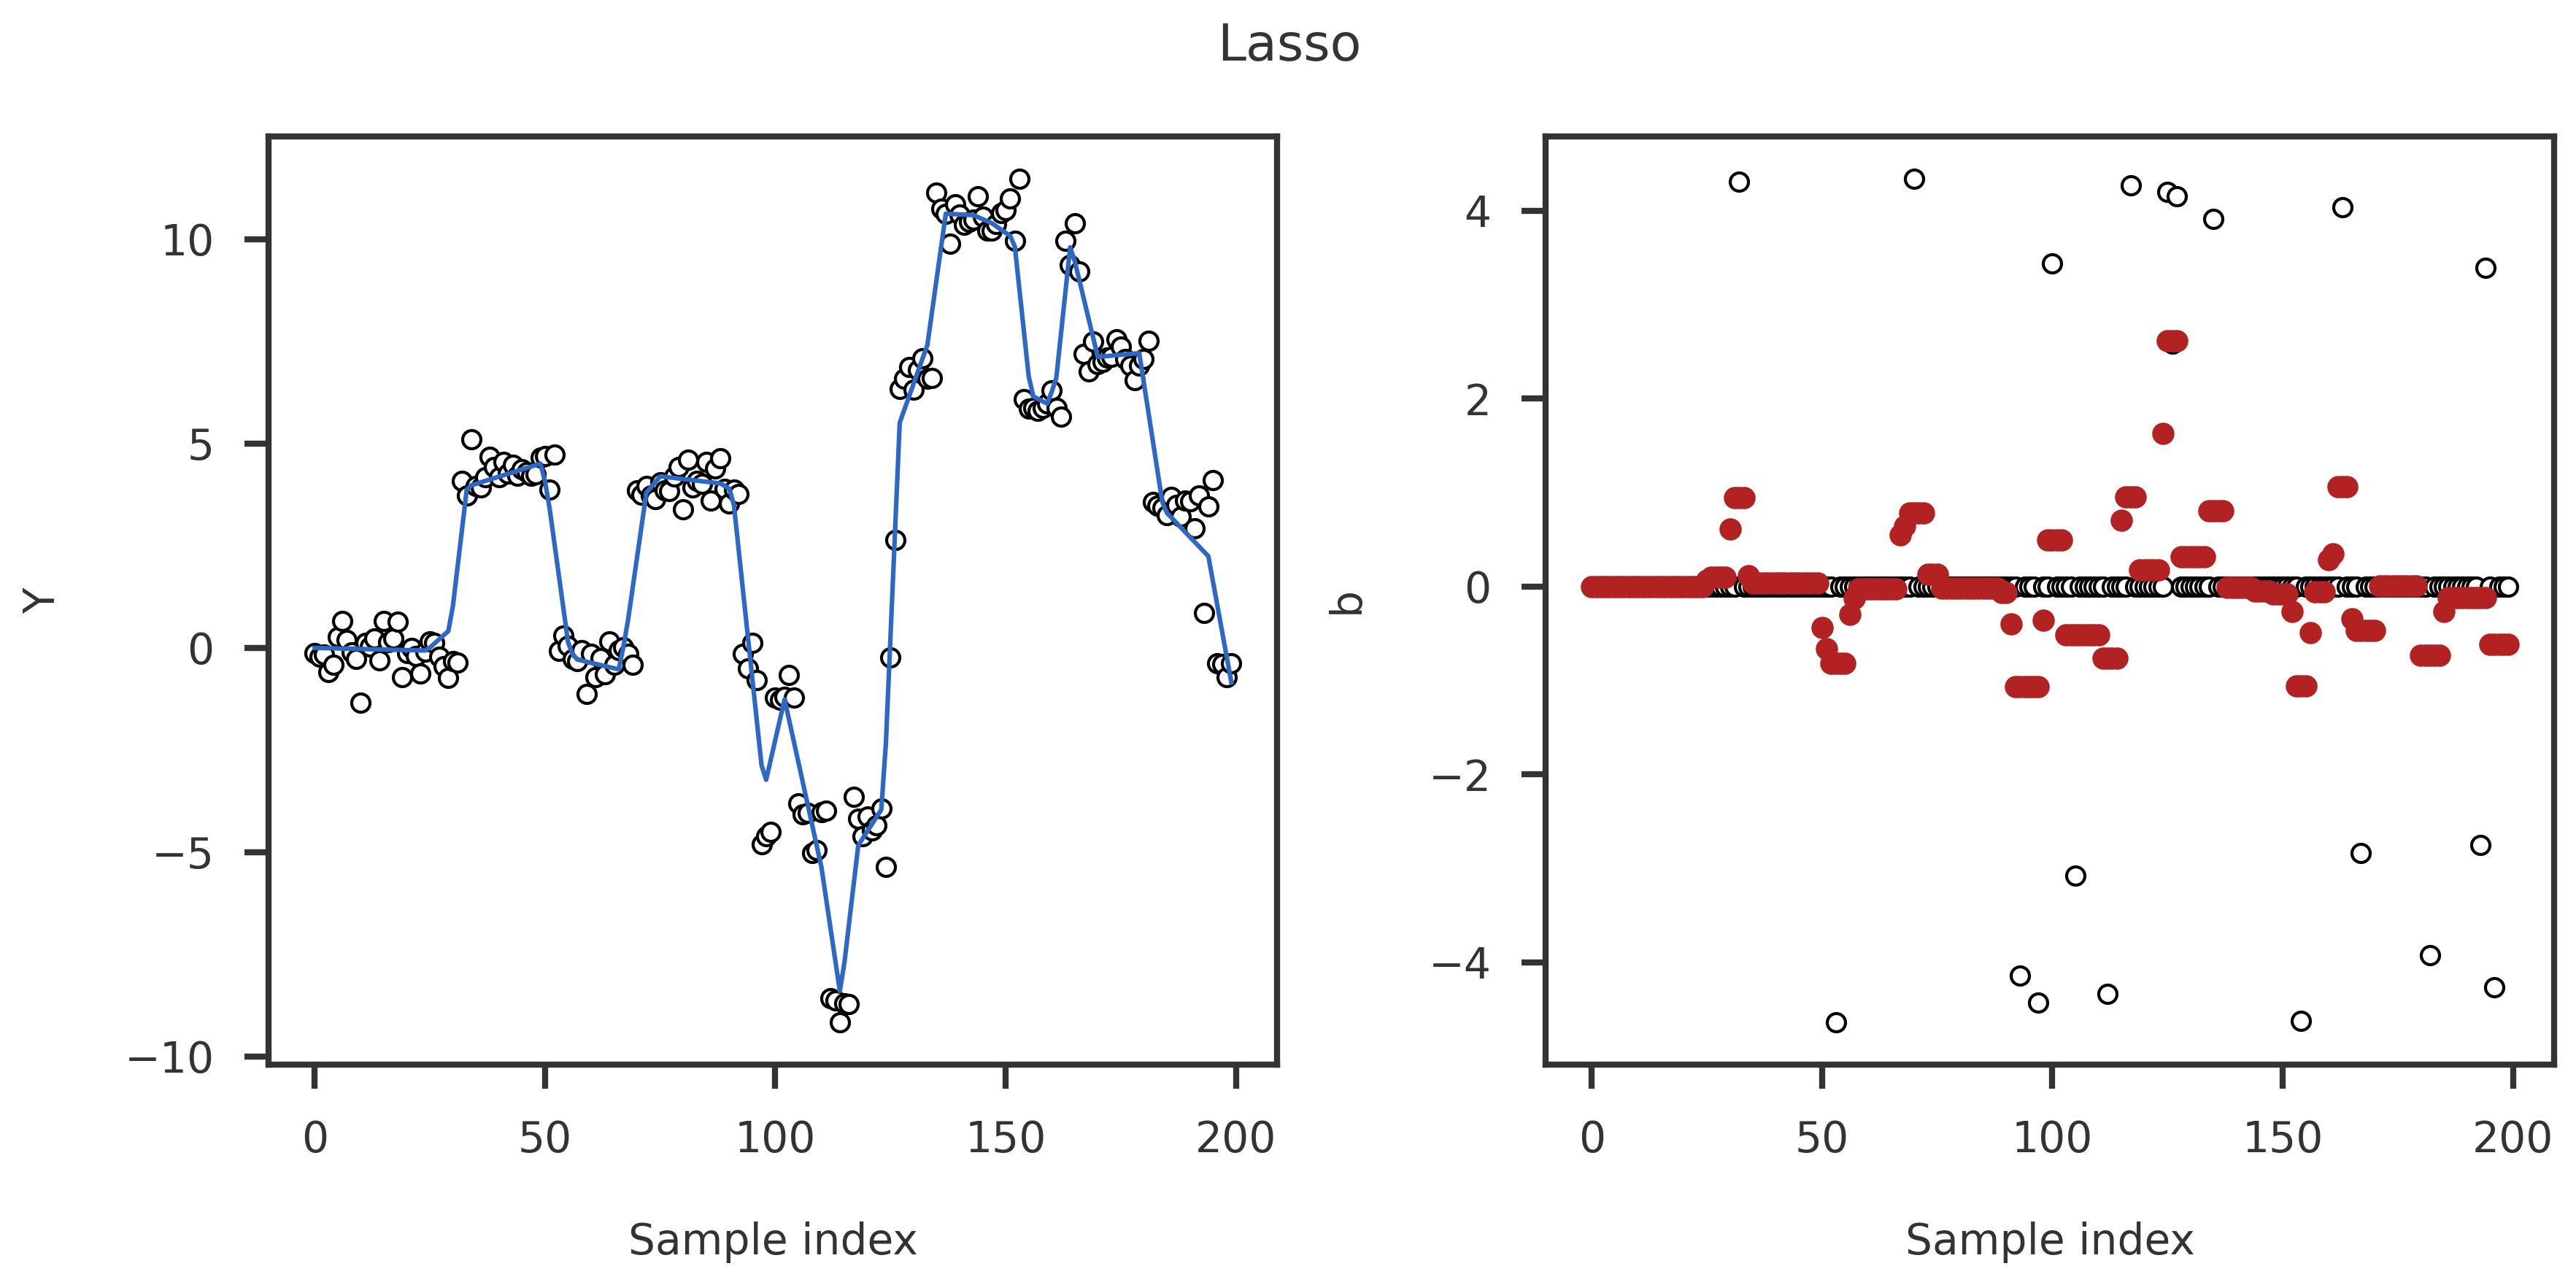

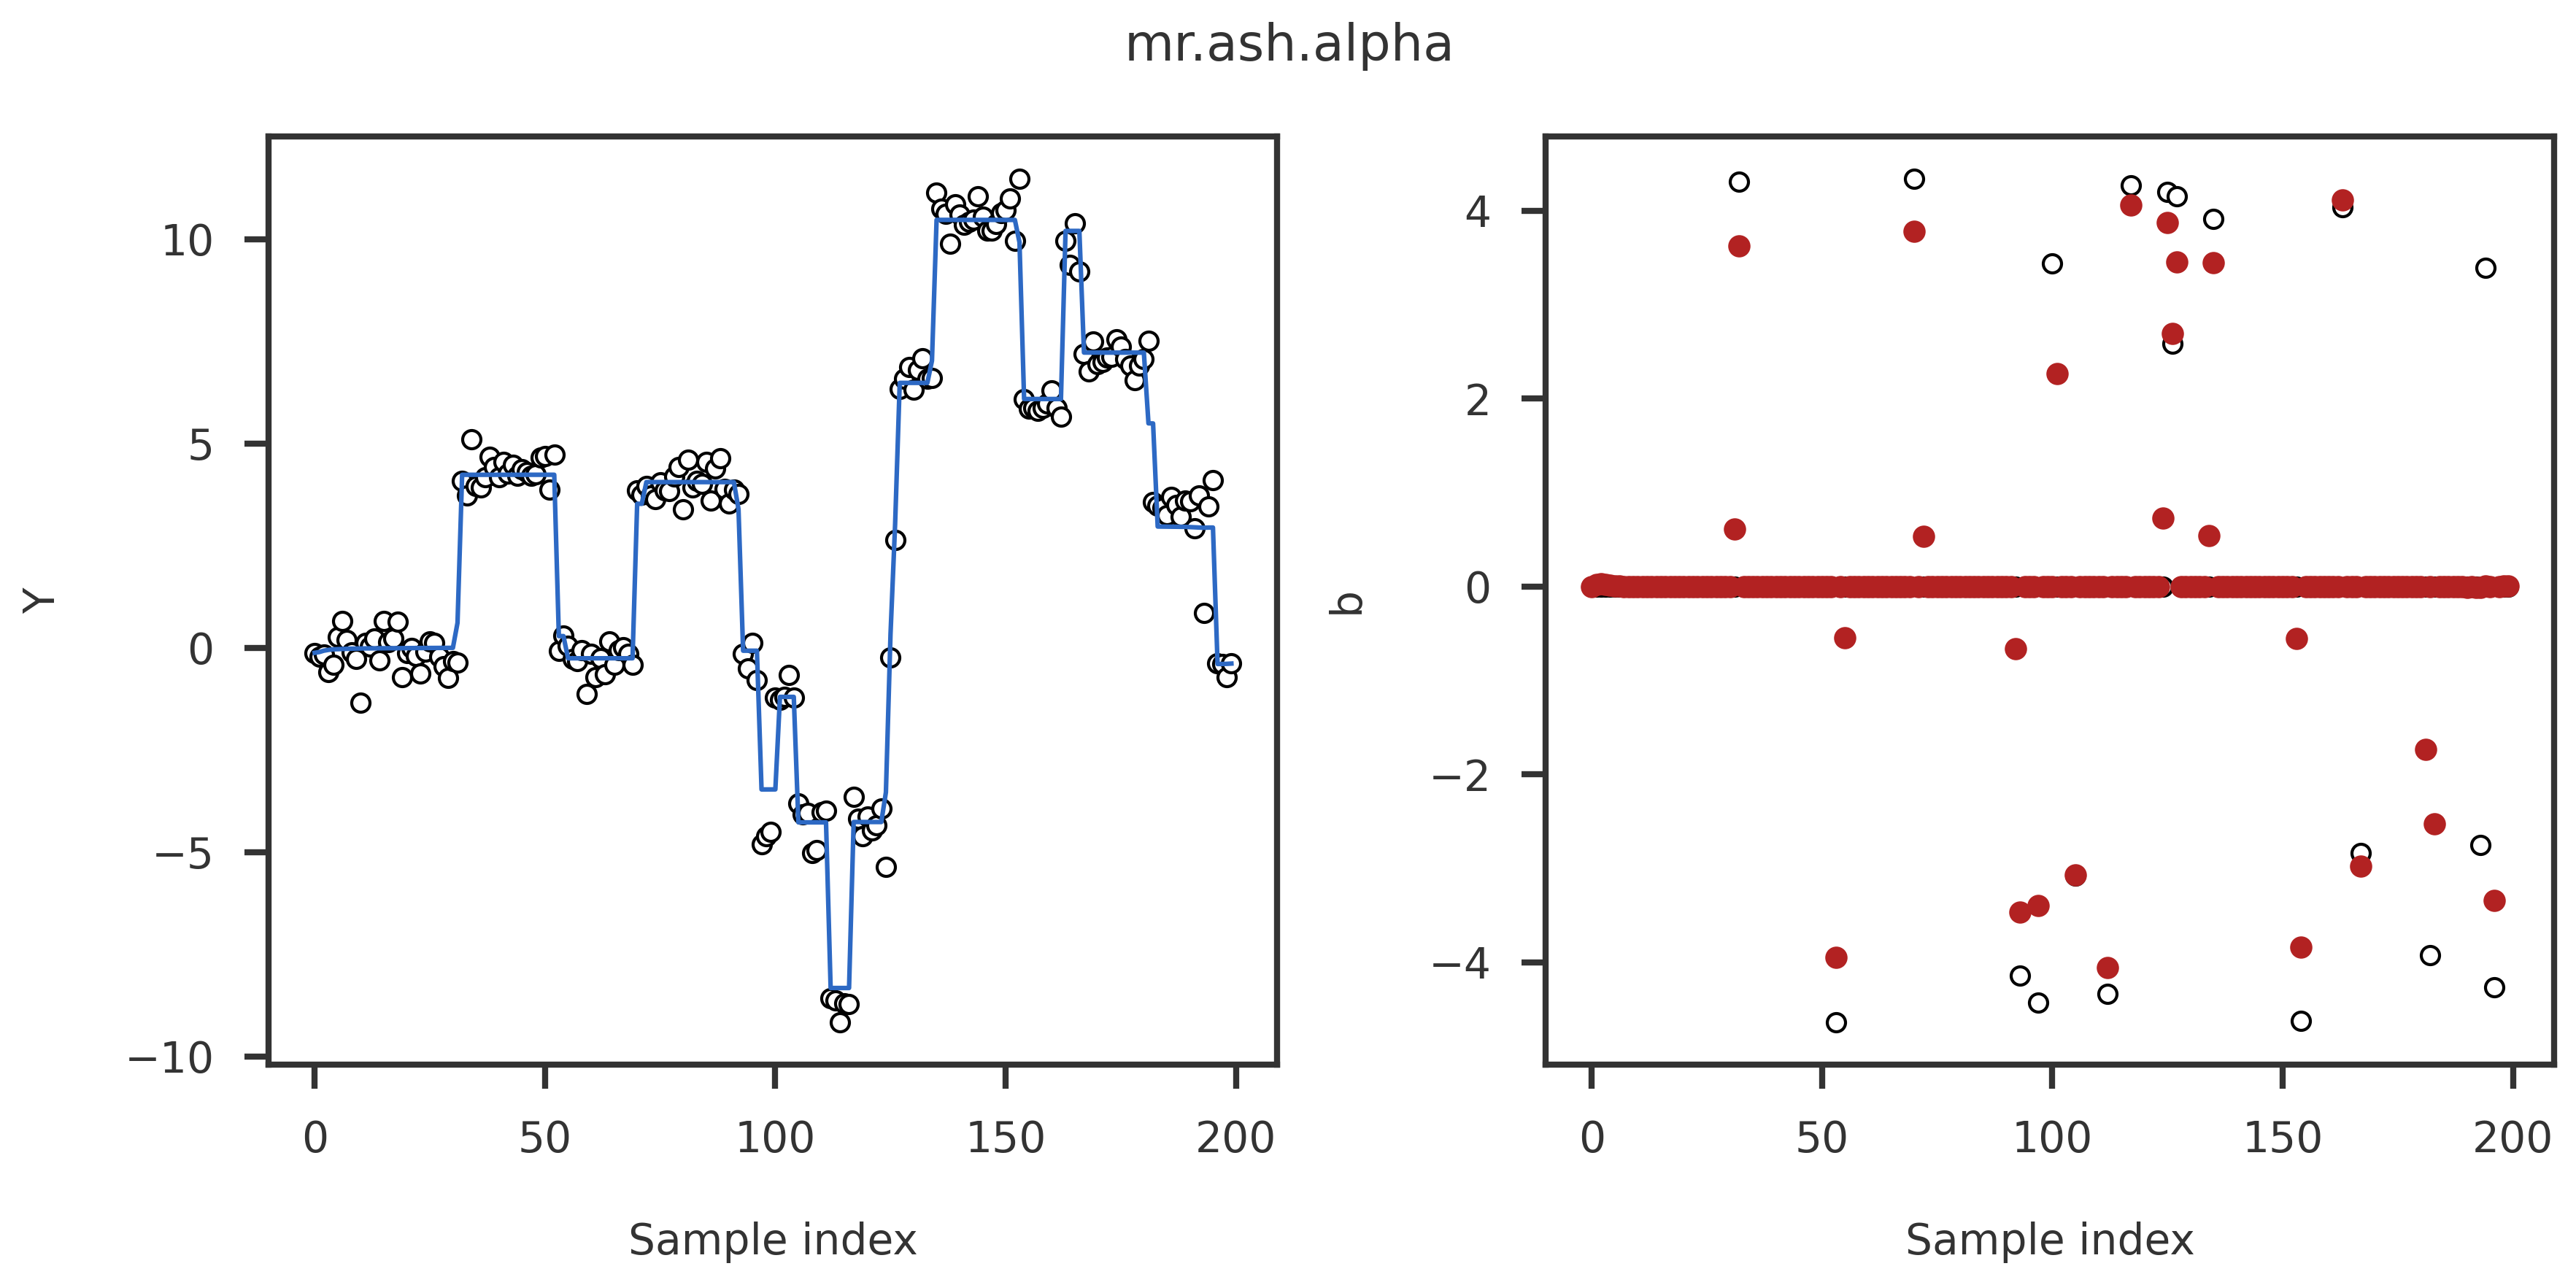

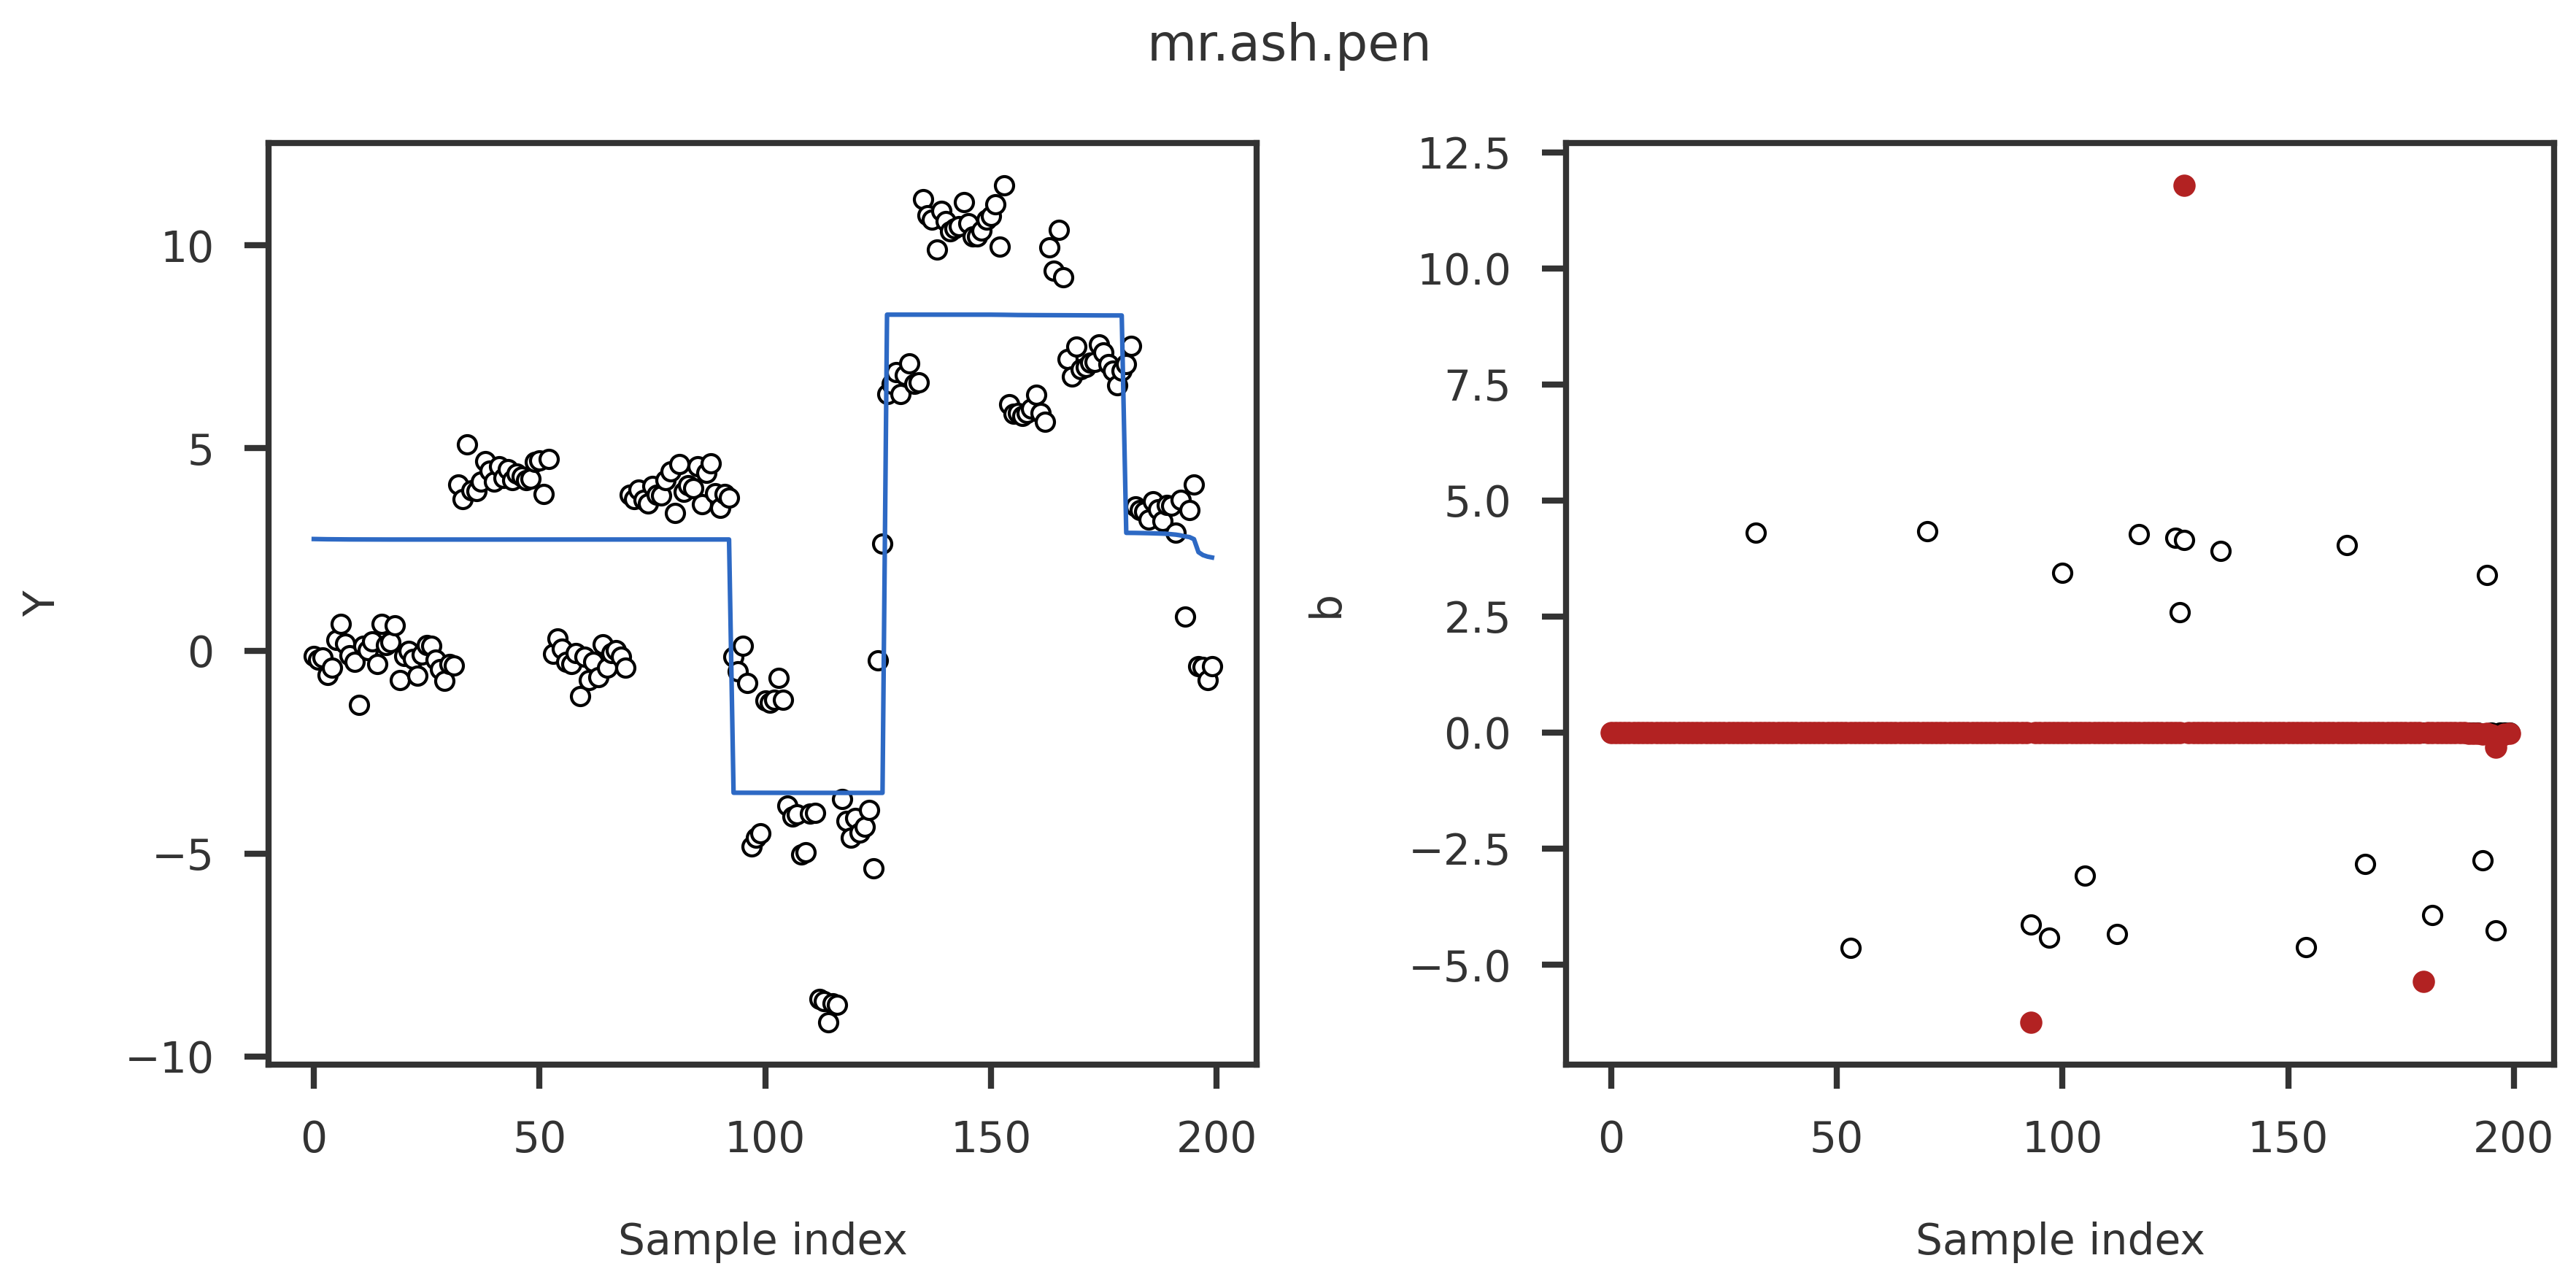

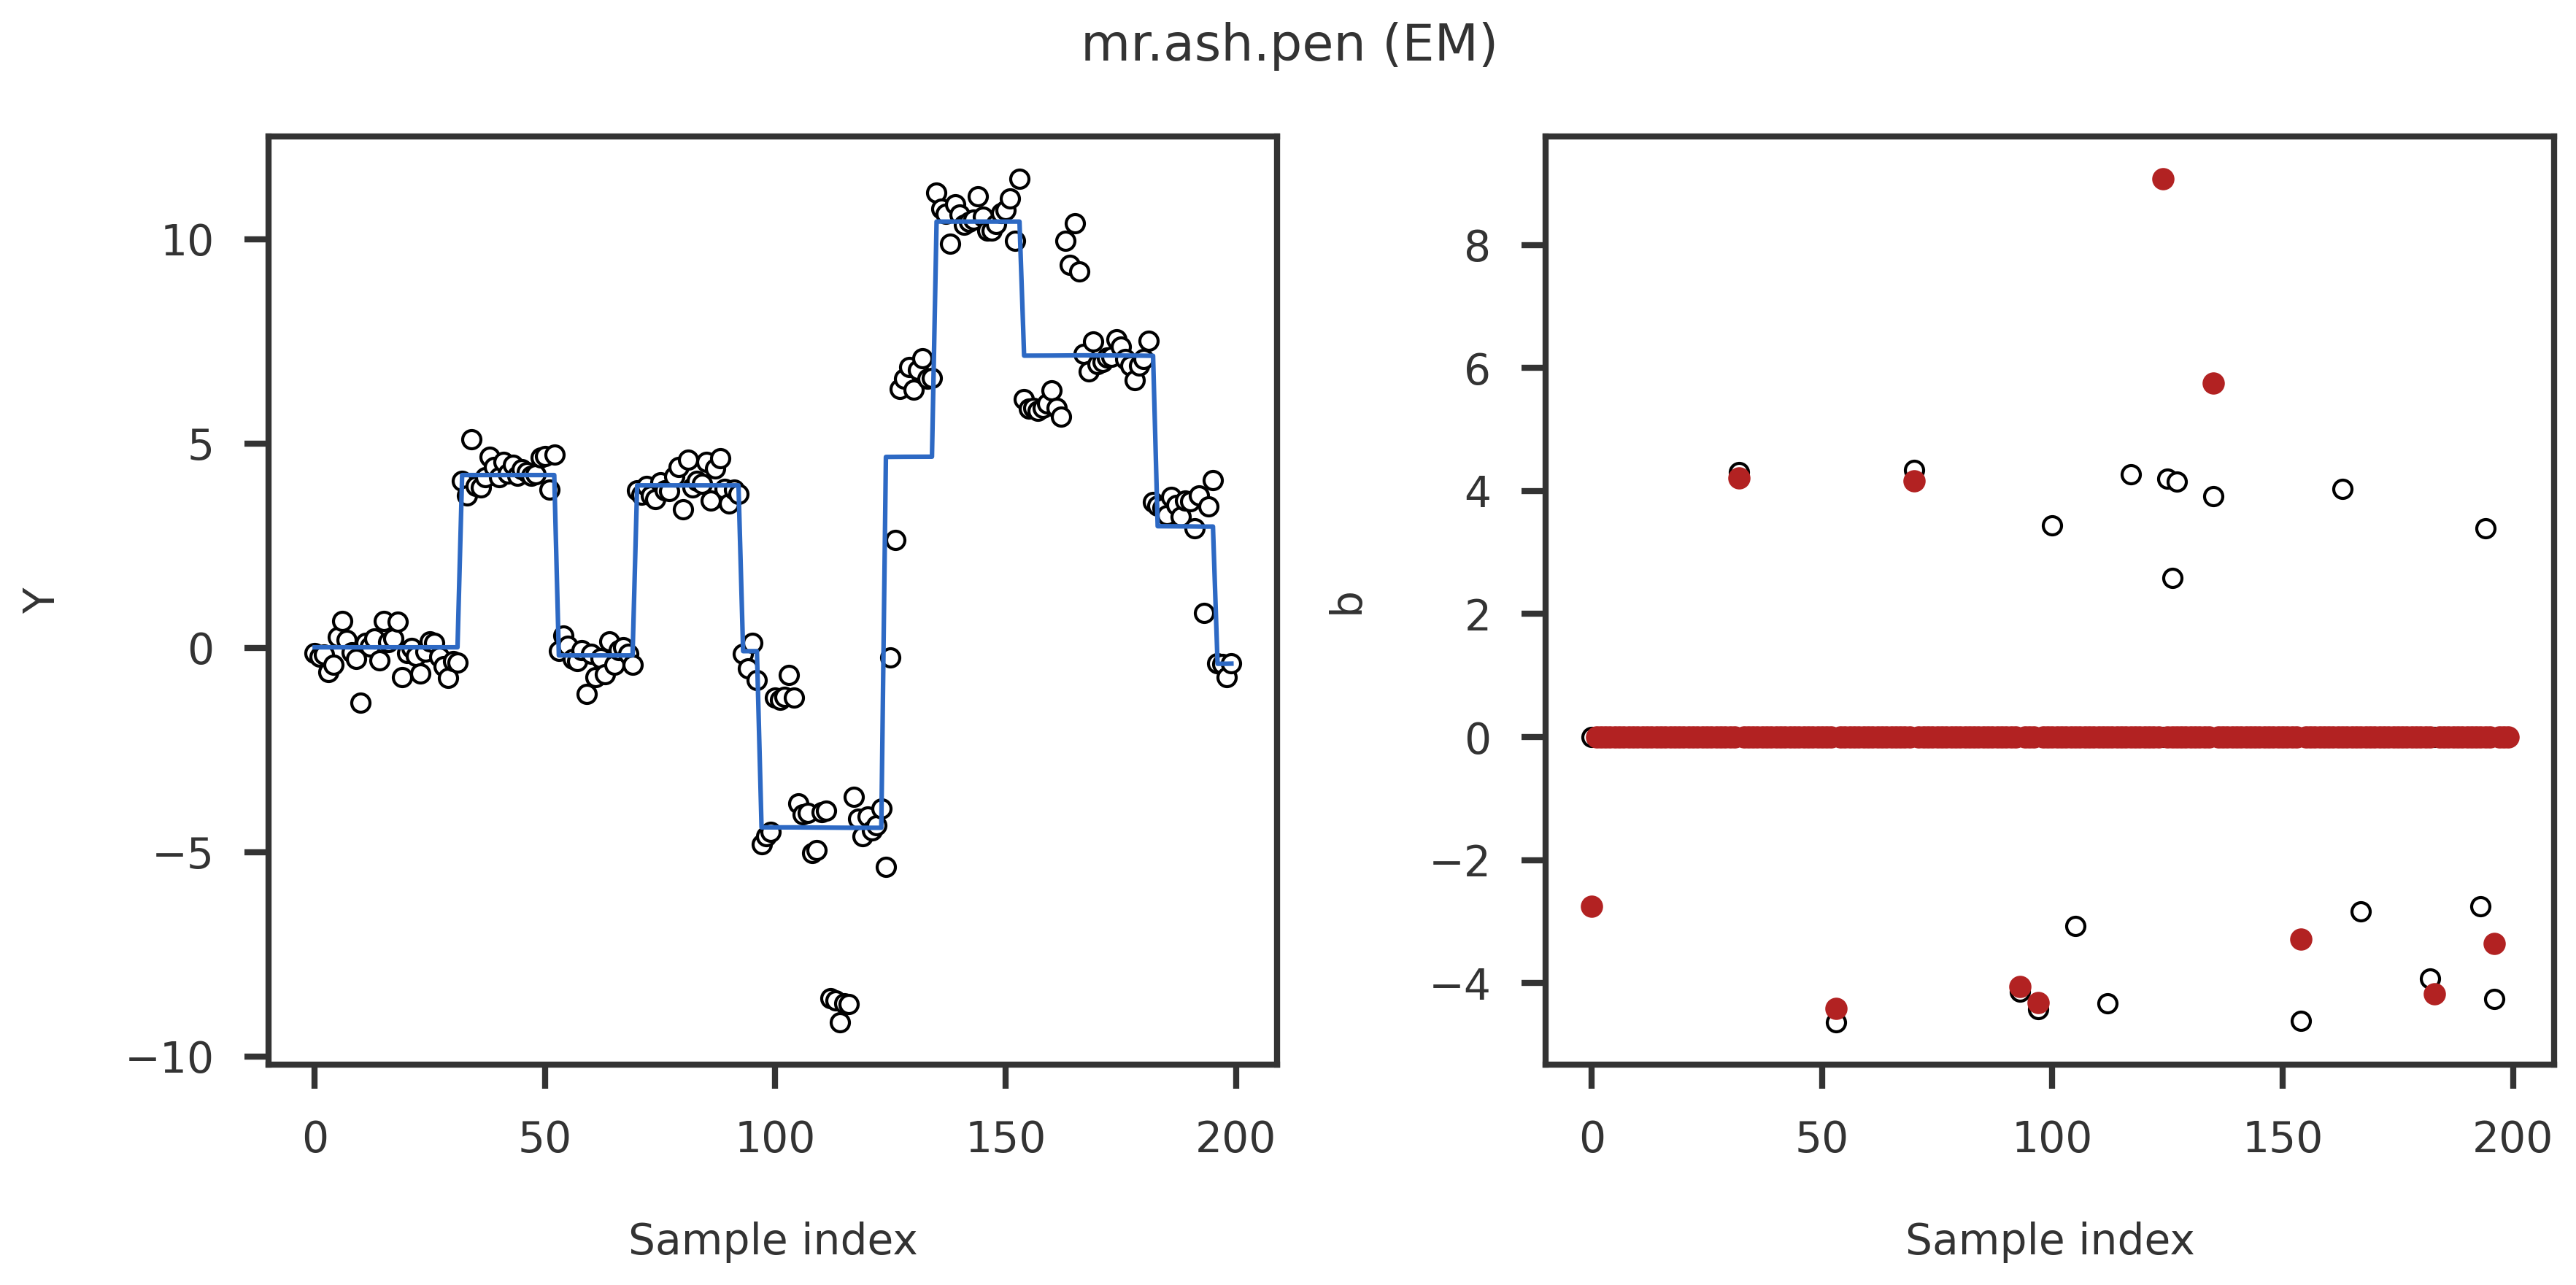

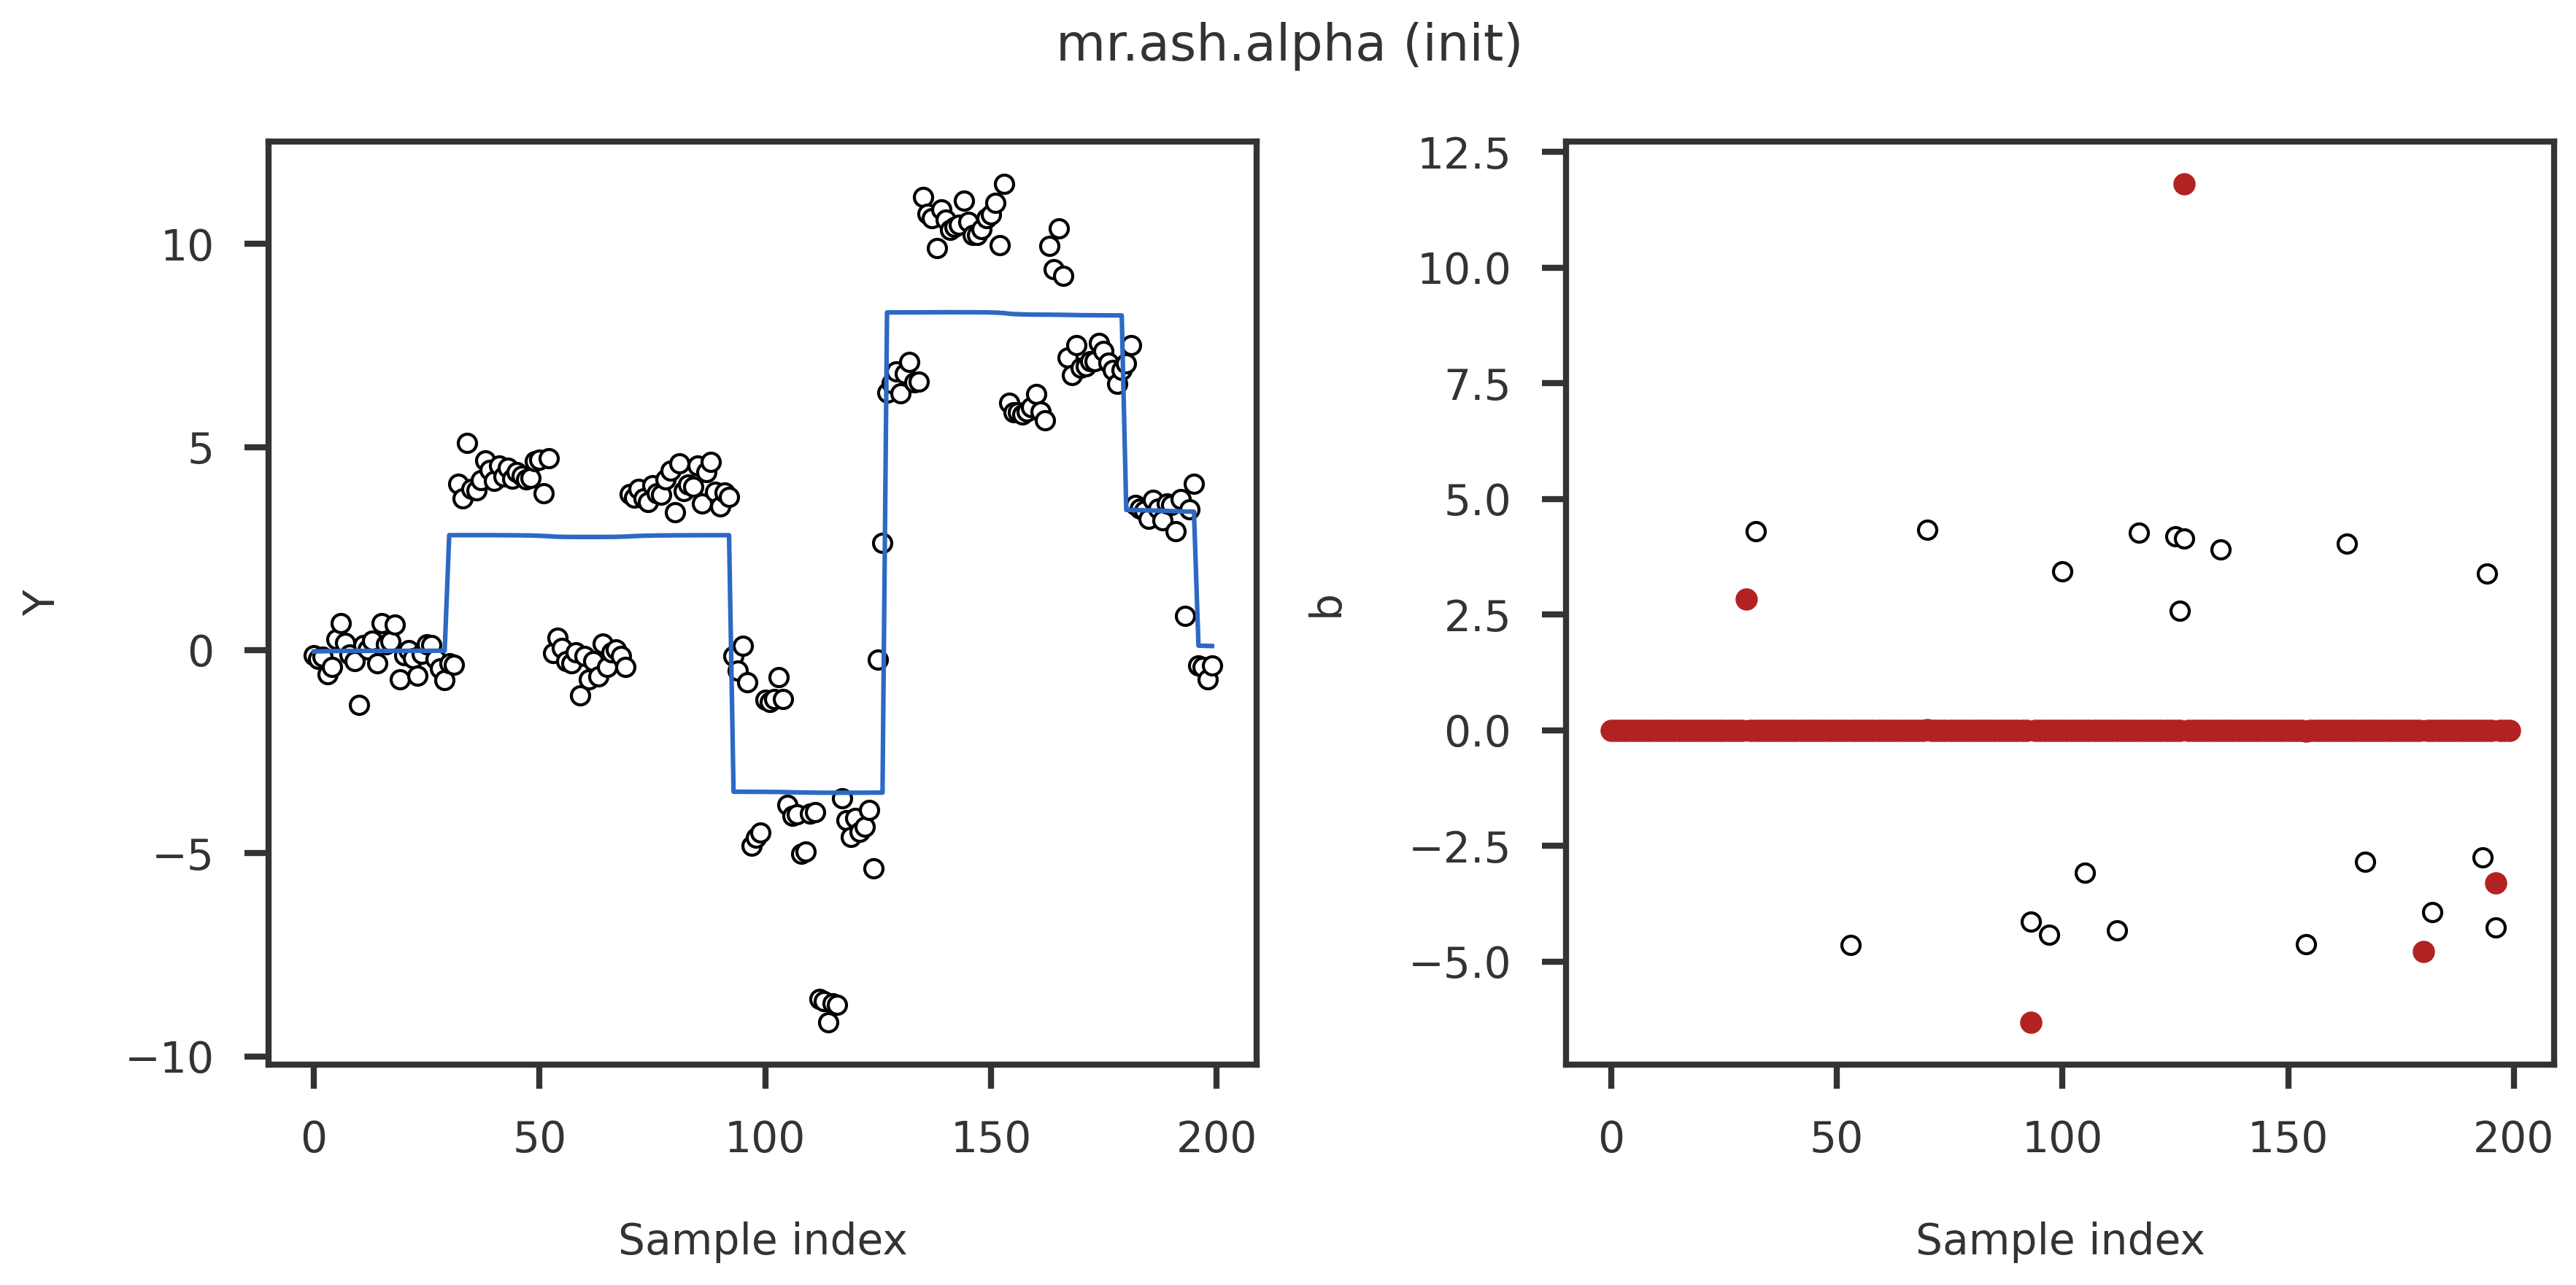

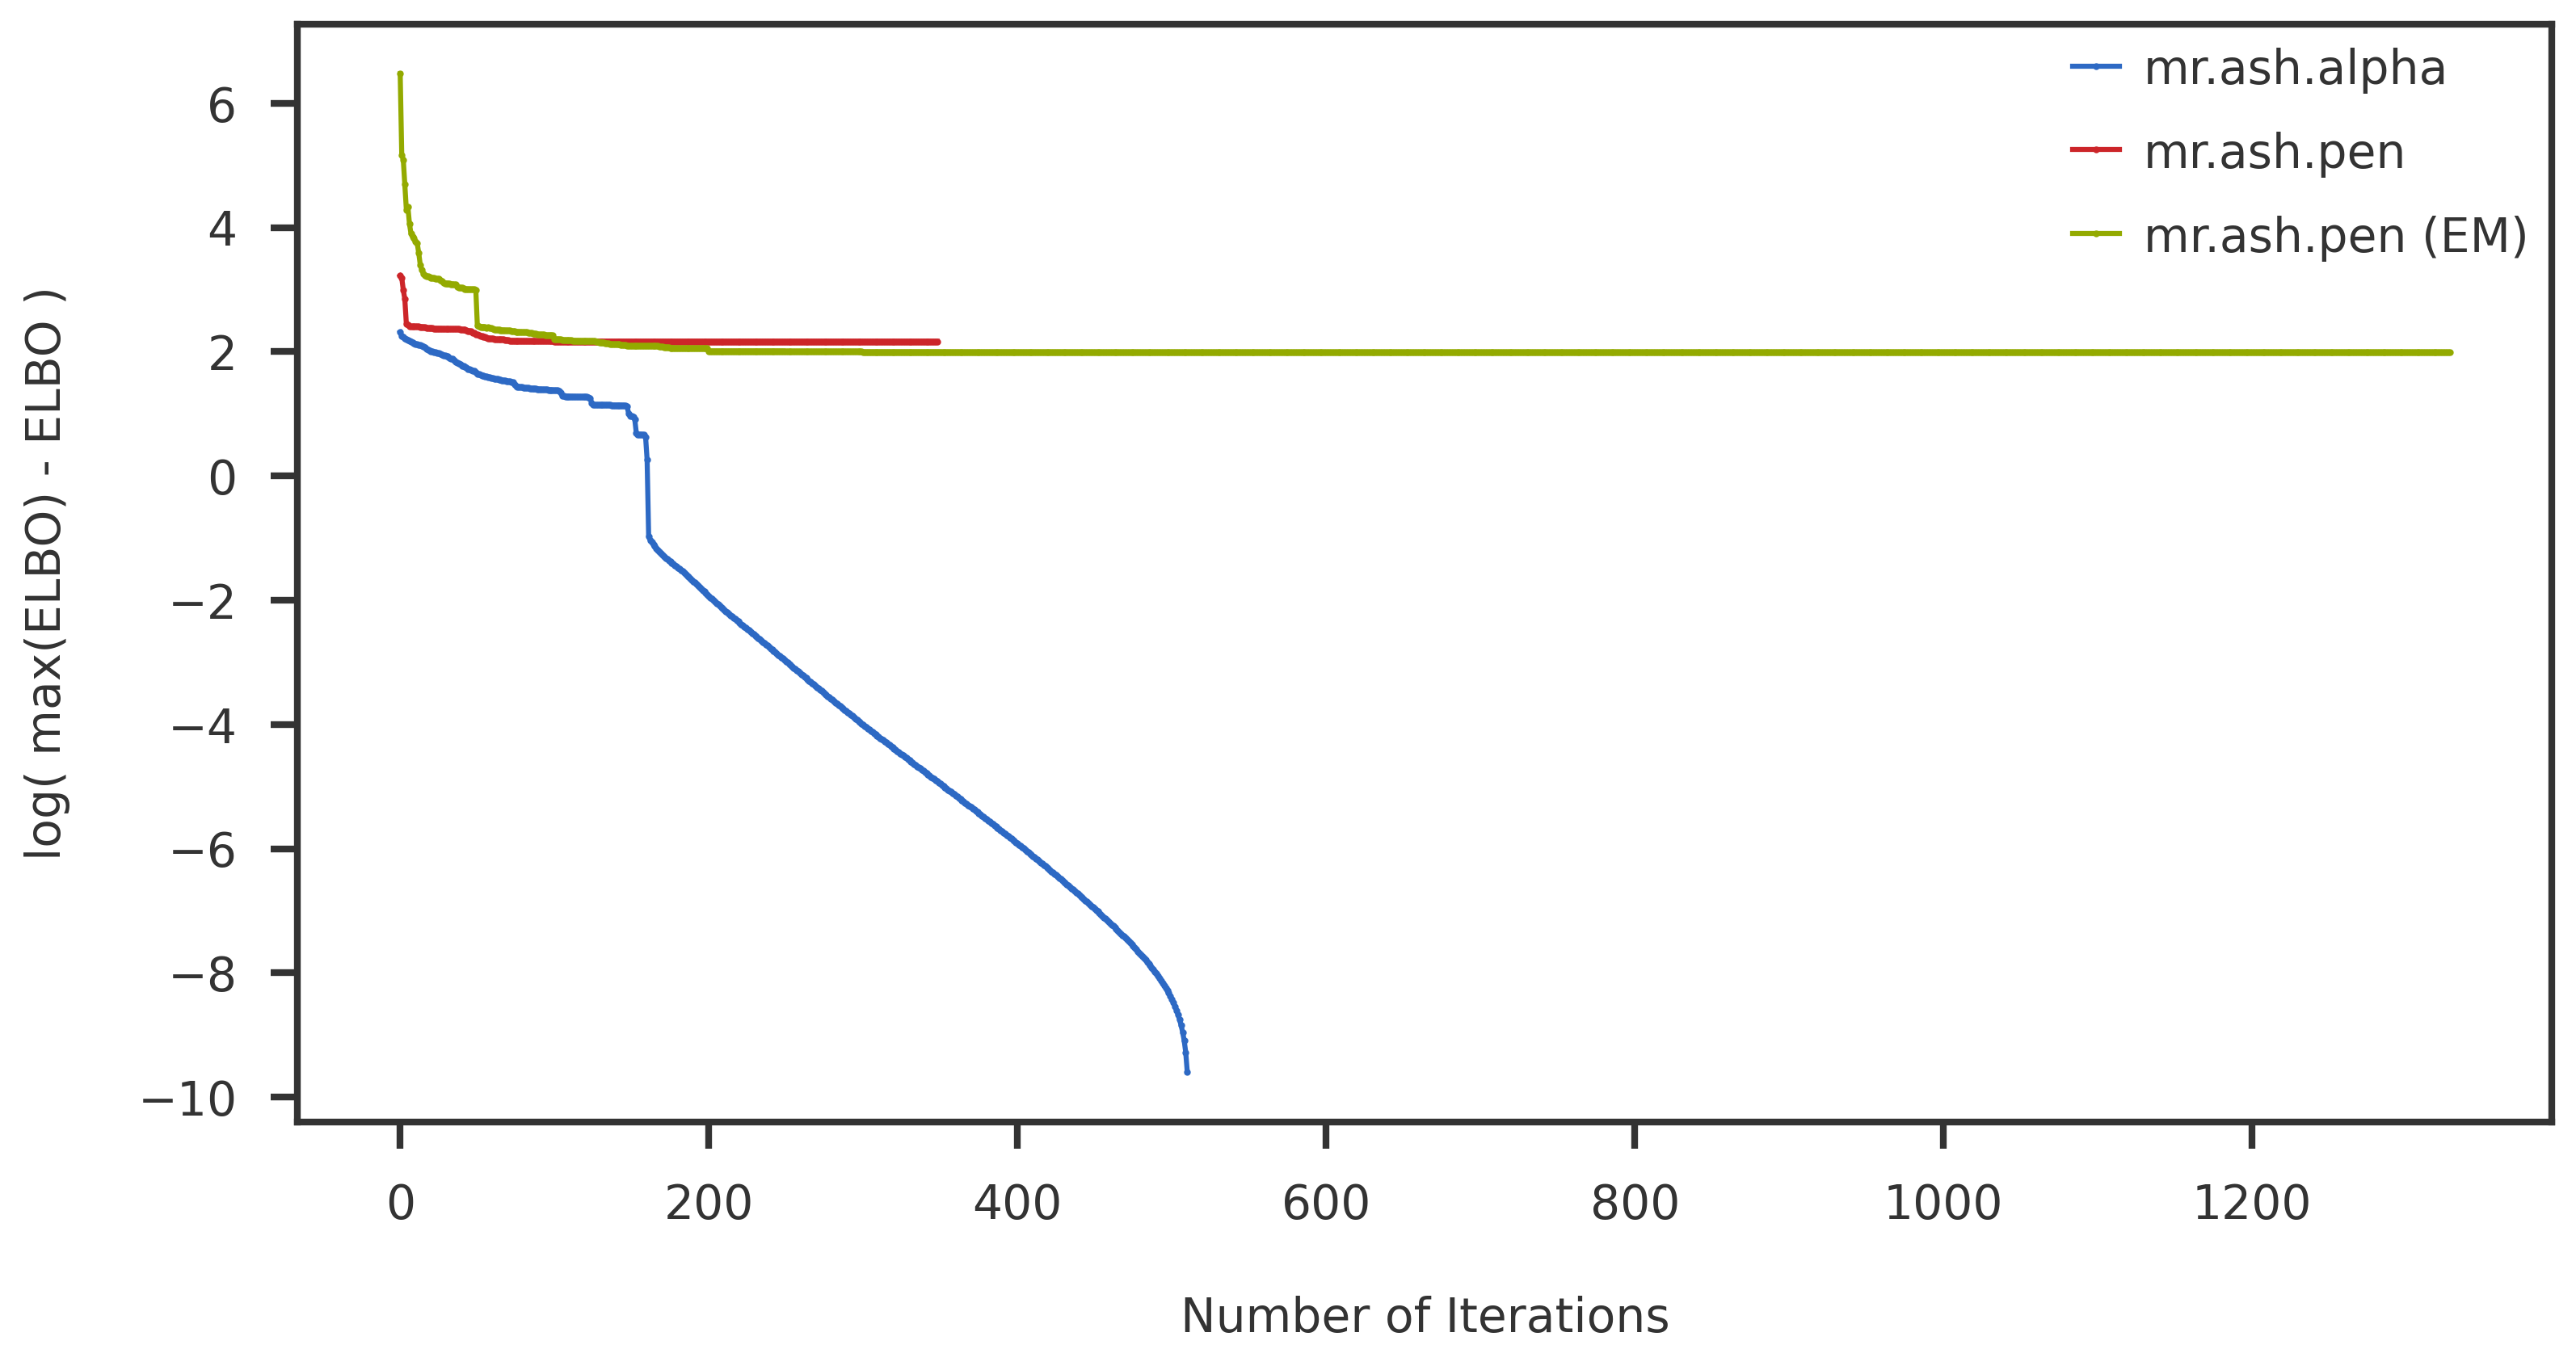

In [104]:
'''
Plot
'''
plot_trendfilter_mrashpen(X, y, btrue, ytest, 
                     genlasso_b, intercept = genlasso_a0, title = 'Lasso')
plot_trendfilter_mrashpen(X, y, btrue, ytest, 
                     mrash_r.coef, intercept = mrash_r.intercept, title = 'mr.ash.alpha')
plot_trendfilter_mrashpen(X, y, btrue, ytest, 
                     plr_lbfgs.coef, intercept = plr_lbfgs.intercept, title = 'mr.ash.pen')
plot_trendfilter_mrashpen(X, y, btrue, ytest, 
                     plr_eb.coef, intercept = plr_eb.intercept, title = 'mr.ash.pen (EM)')
plot_trendfilter_mrashpen(X, y, btrue, ytest, 
                     mrash_r_init.coef, intercept = mrash_r_init.intercept, title = 'mr.ash.alpha (init)')

kinit   = [0, 0, 0]
objs    = [mrash_r.obj_path, plr_lbfgs.elbo_path, plr_eb.elbo_path]
methods = ["mr.ash.alpha", "mr.ash.pen", "mr.ash.pen (EM)"]
# kinit   = [0, 0, 0]
# objs    = [mrash_r.obj_path, plr_lbfgs.elbo_path]
# methods = ["mr.ash.alpha", "mr.ash.pen"]
# kinit   = [0, 0]
# objs    = [plr_lbfgs.elbo_path, plr_eb.outer_elbo_path]
# methods = ["mr.ash.pen", "mr.ash.pen (EM)"]
plot_convergence(objs, methods, kinit)

In [102]:
objs     = [mrash_r, plr_lbfgs, plr_eb, mrash_r_init]
methods  = ["mr.ash.alpha", "mr.ash.pen", "mr.ash.pen (EM)", "mr.ash.alpha (init)"]
df       = linreg_summary_df(strue, objs, methods)
# objs     = [mrash_r, plr_lbfgs, mrash_r_init]
# methods  = ["mr.ash.alpha", "mr.ash.pen", "mr.ash.alpha (init)"]
# df       = linreg_summary_df(strue, objs, methods)
df

,sigma2,ELBO,niter
True,0.150644,-,-
mr.ash.alpha,0.365576,330.762546,512
mr.ash.pen,0.649367,361.387147,555
mr.ash.pen (EM),4.500917,480.58936,893
mr.ash.alpha (init),0.374406,333.424514,188


In [93]:
s2init

0.6493666581724082